In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


In [2]:
DATASET_PATH = "/kaggle/input/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [3]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
test = df
test['subCategory'].value_counts().head(10)

Topwear       1610
Shoes          849
Bags           381
Watches        322
Bottomwear     306
Innerwear      226
Jewellery      145
Fragrance      128
Sandal         113
Wallets        108
Name: subCategory, dtype: int64

In [5]:
# Generating apparel type/color combinations

# df = df[df['masterCategory'] == 'Apparel']
# top_classes = df['articleType'].value_counts().index[:6].to_list()
# top_colors = df['baseColour'].value_counts().index[:6].to_list()
# df = df[df['articleType'].isin(top_classes)]
# df = df[df['baseColour'].isin(top_colors)]
# df = df.reset_index(drop=True)
# clothing_types = df['articleType'].to_list()
# clothing_colors = df['baseColour'].to_list()
# image_names = df['image'].to_list()

# Generating specific fashion type/ color combinations
top_categories = ['Topwear', 'Bottomwear', 'Shoes']
top_colors = ['Black', 'White', "Blue"]

df = df[df['subCategory'].isin(top_categories)]
df = df[df['baseColour'].isin(top_colors)]
df = df.reset_index(drop=True)
clothing_types = df['subCategory'].to_list()
clothing_colors = df['baseColour'].to_list()
image_names = df['image'].to_list()

In [6]:
import cv2
from sklearn.preprocessing import LabelEncoder

data = []
for i, image_name in enumerate(image_names):
    img = cv2.imread(DATASET_PATH + 'images/' + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (64, 64))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    data.append(img)
        
X_train = np.array(data)

y_type = np.array(clothing_types)
y_color = np.array(clothing_colors)

label_encoder = LabelEncoder()

label_encoder.fit(y_type)
type_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

label_encoder.fit(y_color)
color_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

y_type = label_encoder.fit_transform(y_type)
y_color = label_encoder.fit_transform(y_color)

print(type_mapping)
print(color_mapping)

{'Bottomwear': 0, 'Shoes': 1, 'Topwear': 2}
{'Black': 0, 'Blue': 1, 'White': 2}


In [7]:
X_train.shape, y_type.shape, y_color.shape

((1340, 64, 64, 3), (1340,), (1340,))

-4.8428774e-08 1.0000001


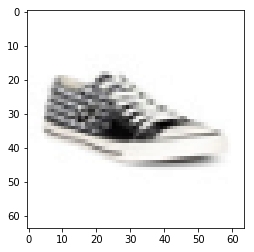

1 0


In [8]:
print(np.amin(X_train), np.amax(X_train))

plt.imshow(X_train[46], interpolation='nearest')
plt.show()
print(y_type[46], y_color[46])

# Model

In [9]:
NUM_TYPES = len(np.unique(y_type))
NUM_COLORS = len(np.unique(y_color))

NUM_TYPES, NUM_COLORS

(3, 3)

In [10]:
# latent space dimension
z = Input(shape=(100,))

# classes
types = Input(shape=(NUM_TYPES,))
colors = Input(shape=(NUM_COLORS,))

# Generator network
merged_layer = Concatenate()([z, types, colors])

# FC: 2x2x1024
generator = Dense(2*2*1024, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 1024))(generator)

# # Conv 1: 4x4x512
generator = Conv2DTranspose(512, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 5: 64x64x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)
generator = Model(inputs=[z, types, colors], outputs=generator, name='generator')

In [11]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 106)          0           input_1[0][0]                    
                                                                 input_2[0][0]            

In [ ]:
# input image
img_input = Input(shape=(X_train[0].shape))

discriminator = Conv2D(32, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, types, colors])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, types, colors], outputs=discriminator, name='discriminator')

In [ ]:
discriminator.summary()

In [ ]:
# # Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

discriminator.trainable = False

# label = Input(shape=(NUM_CLASSES,), name='label')
clothing_type = Input(shape=(NUM_TYPES,), name='type')
clothing_color = Input(shape=(NUM_COLORS,), name='color')
z = Input(shape=(100,), name='z')

fake_img = generator([z, clothing_type, clothing_color])
validity = discriminator([fake_img, clothing_type, clothing_color])

d_g = Model([z, clothing_type, clothing_color], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

# prints a summary representation of your model
d_g.summary()

In [ ]:
epochs = 300
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        # real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_CLASSES)
        real_types = to_categorical(y_type[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_TYPES)
        real_colors = to_categorical(y_color[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_COLORS)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_types, real_colors],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        # random_labels = to_categorical(np.random.randint(0, NUM_CLASSES, batch_size).reshape(-1, 1), num_classes=NUM_CLASSES)
        random_types = to_categorical(y_type[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_TYPES)
        random_colors = to_categorical(y_color[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_COLORS)
        X_fake = generator.predict_on_batch([z, random_types, random_colors])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_types, random_colors], y=fake)
  
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        # random_labels = to_categorical(np.random.randint(0, NUM_CLASSES, batch_size).reshape(-1, 1), num_classes=NUM_CLASSES)
        random_types = to_categorical(y_type[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_TYPES)
        random_colors = to_categorical(y_color[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=NUM_COLORS)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_types, random_colors], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 3 * 3
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        # labels = to_categorical(np.arange(0, NUM_CLASSES).reshape(-1, 1), NUM_CLASSES)
        
        types = to_categorical(np.arange(0, NUM_TYPES).reshape(-1, 1), NUM_TYPES)
        all_types = np.concatenate([np.vstack([cType] * 3) for cType in types]) 
        
        colors = to_categorical(np.arange(0, NUM_COLORS).reshape(-1, 1),  NUM_COLORS)
        all_colors = np.vstack([colors] * 3)
        
        x_fake = generator.predict([z, all_types, all_colors])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(3, 3, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            # plt.title(class_names[k])
            plt.title(k)

        plt.tight_layout()
        plt.show()